# Redistricting - Putnam, FL County Commissioner Districts

### Code used to generate a sample of redistricting plans that optimize for the creation of a majority-minority Gingles I district

*************************

Draw a illustrative map that:
- creates a 5 district SMD County Commissioner districts
- keeps absolute deviations under 5%
- analyze if it is possible to create one or more majority-minority Gingles I districts
- avoid splitting precincts when possible
- is compact and contiguous
- keep COI entact


In [1]:
from pygris import counties
import maup
import pandas as pd
import geopandas as gp
import networkx as nx
from functools import partial
import matplotlib.pyplot as plt
from statistics import mean
plt.style.use('ggplot')
# import warnings
# warnings.filterwarnings('ignore')

**Load data**

In [2]:
# Load blocks for Putnam County, FL
fl_tiger = counties(state = "FL", cache = True)
putnam = fl_tiger[fl_tiger["NAME"] == "Putnam"]
putnam = putnam.to_crs(epsg=32616)

blocks = gp.read_file("./raw_data/fl_pl2020_b/fl_pl2020_b.shp", mask=putnam)
blocks[blocks.COUNTYFP20=="107"].P0010001.sum() # check population
blocks = blocks[blocks.COUNTYFP20=="107"]

# current districts
current_districts = gp.read_file("./raw_data/current_districts/County_Districts_hub/County_Districts_hub.shp")

# # VTDs
# vtds = gp.read_file("./raw_data/fl_pl2020_vtd/fl_pl2020_vtd.shp", mask=putnam)
# vtds = vtds[vtds.COUNTYFP20=="107"]

# CVAP data



Using the default year of 2021
Using FIPS code '12' for input 'FL'


In [3]:
cvap = pd.read_csv('./raw_data/fl_cvap_2020_2020_b/fl_cvap_2020_2020_b.csv')
cvap.GEOID20 = cvap.GEOID20.astype(str)
cvap = cvap[cvap.GEOID20.isin(blocks['GEOID'].str[-15:].tolist())]

In [4]:
blocks = blocks.\
  merge(cvap[['GEOID20', 'CVAP_TOT20', 'CVAP_BLK20', 'CVAP_ASN20', 'CVAP_AIA20', 'CVAP_NHP20', 'CVAP_HSP20', 'CVAP_WHT20']],\
    left_on=blocks['GEOID'].str[-15:], right_on='GEOID20', how='left')

In [5]:
blocks = blocks.to_crs(epsg=32617)
current_districts = current_districts.to_crs(epsg=32617)
# vtds = vtds.to_crs(epsg=32617)

blocks["geometry"] = blocks.buffer(0)
current_districts["geometry"] = current_districts.buffer(0)
# vtds["geometry"] = vtds.buffer(0)

# vtds.reset_index(inplace=True)
blocks.reset_index(inplace=True)

### Assign blocks to current districts

In [6]:
distict_assign = maup.assign(blocks, current_districts)
blocks['current_district'] = [current_districts.iloc[x]['DISTRICTID'] for x in distict_assign.tolist()]

Census Public Law 94-171 fields: https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/complete-tech-docs/summary-file/2020Census_PL94_171Redistricting_StatesTechDoc_English.pdf

- P0010001 = total population
- P0010003 = total population: white alone
- P0010004 = total population: black alone
- P0010005 = total population: american indian and alaska native alone
- P0010006 = total population: asian alone
- P0010007 = total population: native hawaiian and other pacific islander alone
- P0010007 = total population: some other
- P0010009 = total population: two or more

*******************

- P0020002 = total population: hispanic or latino
- P0020005 = total population: white alone, not hispanic or latino
- P0020006 = total population: black alone, not hispanic or latino
- P0020007 = total population: american indian and alaska native alone, not hispanic or latino
- P0020008 = total population: asian alone, not hispanic or latino
- P0020009 = total population: native hawaiian and other pacific islander alone, not hispanic or latino
- P0020010 = total population: some other, not hispanic or latino
- P0020011 = total population: two or more, not hispanic or latino

*******************

- P0030001 = total population 18 and over
- P0030003 = total population 18 and over: white alone
- P0030004 = total population 18 and over: black alone
- P0030005 = total population 18 and over: american indian and alaska native alone
- P0030006 = total population 18 and over: asian alone
- P0030007 = total population 18 and over: native hawaiian and other pacific islander alone
- P0030008 = total population 18 and over: some other
- P0030009 = total population 18 and over: two or more


*******************

- P0040001 = total population 18 and over
- P0040002 = total population 18 and over: hispanic or latino
- P0040005 = total population 18 and over: white alone, not hispanic or latino
- P0040006 = total population 18 and over: black alone, not hispanic or latino
- P0040007 = total population 18 and over: american indian and alaska native alone, not hispanic or latino
- P0040008 = total population 18 and over: asian alone, not hispanic or latino
- P0040009 = total population 18 and over: native hawaiian and other pacific islander alone, not hispanic or latino
- P0040010 = total population 18 and over: some other, not hispanic or latino
- P0040011 = total population 18 and over: two or more, not hispanic or latino

In [7]:
# black alone or in combination (32 categories)
black_demo_cols = ['P0010004', 'P0010011', 'P0010016', 'P0010017', 'P0010018', 'P0010019', 'P0010027', 'P0010028', 'P0010029', 'P0010030', \
'P0010037', 'P0010038', 'P0010039', 'P0010040', 'P0010041', 'P0010042',  'P0010048', 'P0010049', 'P0010050', 'P0010051', \
'P0010052', 'P0010053', 'P0010058', 'P0010059', 'P0010060', 'P0010061', 'P0010064', 'P0010065', 'P0010066', 'P0010067', 'P0010069', 'P0010071']

blocks['abpop'] = blocks[black_demo_cols].sum(axis=1)

nh_black_demo_cols = ['P0020006', 'P0020013', 'P0020018', 'P0020019', 'P0020020', 'P0020021', 'P0020029', 'P0020030', 'P0020031', 'P0020032', \
'P0020039', 'P0020040', 'P0020041', 'P0020042', 'P0020043', 'P0020044',  'P0020050', 'P0020051', 'P0020052', 'P0020053', \
'P0020054', 'P0020055', 'P0020060', 'P0020061', 'P0020062', 'P0020063', 'P0020066', 'P0020067', 'P0020068', 'P0020069', 'P0020071', 'P0020073']

# hispanic or latino (not enumerated as black)
blocks['hpop'] = blocks['P0020002'] - ( 
  blocks[black_demo_cols].sum(axis=1) \
  - blocks[nh_black_demo_cols].sum(axis=1)
)

nh_asian_demo_cols = ['P0020008', 'P0020015', 'P0020022' , 'P0020025', 'P0020026', 'P0020033', 'P0020036', 'P0020037', 'P0020045',\
  'P0020046','P0020048','P0020056','P0020057','P0020059','P0020064', 'P0020070',\
    'P0020009', 'P0020016', 'P0020023', 'P0020027', 'P0020034', 'P0020038', 'P0020047', 'P0020058']
blocks['aapop'] = blocks[nh_asian_demo_cols].sum(axis=1)

# native american alone or in combination (not enumerated as black, asian or hispanic)
blocks['anapop'] = blocks[['P0020007', 'P0020014', 'P0020024', 'P0020035']].sum(axis=1)

# other race (not enumerated as black, asian, hispanic, or native american)
blocks['opop'] = blocks[['P0020010', 'P0020017']].sum(axis=1)

# white 
blocks['wpop'] = blocks['P0020005']


In [8]:
blocks[[ 'abpop', 'aapop', 'hpop', 'anapop', 'opop', 'wpop']].sum(axis=0)

abpop     12490
aapop       751
hpop       7420
anapop     1435
opop        684
wpop      50541
dtype: int64

In [9]:
# Calculate counts
counts = blocks[['abpop', 'aapop', 'hpop', 'anapop', 'opop', 'wpop']].sum(axis=0)

# Calculate proportions
total_population = counts.sum()
proportions = round((counts / total_population)*100,2)
proportions_with_percent = proportions.astype(str) + '%'

# Combine counts and proportions into a single DataFrame and display
print(pd.DataFrame({"Counts": counts, "Proportions": proportions_with_percent}))


        Counts Proportions
abpop    12490      17.03%
aapop      751       1.02%
hpop      7420      10.12%
anapop    1435       1.96%
opop       684       0.93%
wpop     50541      68.93%


In [10]:
blocks[[ 'abpop', 'aapop', 'hpop', 'anapop', 'opop', 'wpop']].sum(axis=0).sum()

73321

In [11]:
# black alone or in combination (32 categories)
black_demo_cols = ['P0030004', 'P0030011', 'P0030016', 'P0030017', 'P0030018', 'P0030019', 'P0030027', 'P0030028', 'P0030029', 'P0030030', \
'P0030037', 'P0030038', 'P0030039', 'P0030040', 'P0030041', 'P0030042',  'P0030048', 'P0030049', 'P0030050', 'P0030051', \
'P0030052', 'P0030053', 'P0030058', 'P0030059', 'P0030060', 'P0030061', 'P0030064', 'P0030065', 'P0030066', 'P0030067', 'P0030069', 'P0030071']

blocks['abvap'] = blocks[black_demo_cols].sum(axis=1)

nh_black_demo_cols = ['P0040006', 'P0040013', 'P0040018', 'P0040019', 'P0040020', 'P0040021', 'P0040029', 'P0040030', 'P0040031', 'P0040032', \
'P0040039', 'P0040040', 'P0040041', 'P0040042', 'P0040043', 'P0040044',  'P0040050', 'P0040051', 'P0040052', 'P0040053', \
'P0040054', 'P0040055', 'P0040060', 'P0040061', 'P0040062', 'P0040063', 'P0040066', 'P0040067', 'P0040068', 'P0040069', 'P0040071', 'P0040073']

# hispanic or latino (not enumerated as black)
blocks['hvap'] = blocks['P0040002'] - ( 
  blocks[black_demo_cols].sum(axis=1) \
  - blocks[nh_black_demo_cols].sum(axis=1)
)

# asian alone or in combination (not enumerated as black)
nh_asian_demo_cols = ['P0040008', 'P0040015', 'P0040022' , 'P0040025', 'P0040026', 'P0040033', 'P0040036', 'P0040037', 'P0040045',\
  'P0040046','P0040048','P0040056','P0040057','P0040059','P0040064', 'P0040070',\
    'P0040009', 'P0040016', 'P0040023', 'P0040027', 'P0040034', 'P0040038', 'P0040047', 'P0040058']
blocks['aavap'] = blocks[nh_asian_demo_cols].sum(axis=1)

# native american alone or in combination (not enumerated as black, asian or hispanic)
blocks['anavap'] = blocks[['P0040007', 'P0040014', 'P0040024', 'P0040035']].sum(axis=1)

# other race (not enumerated as black, asian, hispanic, or native american)
blocks['ovap'] = blocks[['P0040010', 'P0040017']].sum(axis=1)

# white 
blocks['wvap'] = blocks['P0040005']


In [12]:
counts = blocks[[ 'abvap', 'aavap', 'hvap', 'anavap', 'ovap', 'wvap']].sum(axis=0)

total_population = counts.sum()
proportions = round((counts / total_population)*100,2)
proportions_with_percent = proportions.astype(str) + '%'

print(pd.DataFrame({"Counts": counts, "Proportions": proportions_with_percent}))


        Counts Proportions
abvap     8668       14.9%
aavap      573       0.98%
hvap      4862       8.36%
anavap    1173       2.02%
ovap       518       0.89%
wvap     42390      72.86%


In [13]:
blocks[[ 'abvap', 'aavap', 'hvap', 'anavap', 'ovap', 'wvap']].sum(axis=1).sum()

58184

In [14]:
# check sums (should return empty)
blocks[blocks[[ 'abvap', 'aavap', 'hvap', 'anavap', 'ovap', 'wvap']].sum(axis=1) != blocks['P0040001']][['P0030001', 'P0040001','abvap', 'aavap', 'hvap', 'anavap', 'ovap', 'wvap']]

,P0030001,P0040001,abvap,aavap,hvap,anavap,ovap,wvap


In [15]:
# Subset to demographic columns of interest
demo_cols = ['P0010001', 'P0040001', \
            'abpop', 'aapop', 'hpop', 'anapop', 'opop', 'wpop',\
            'abvap', 'aavap', 'hvap', 'anavap', 'ovap', 'wvap']
cvap_cols = [i for i in blocks.columns if 'CVAP' in i] 

blocks = blocks[['GEOID', 'current_district', 'PLACE','BLKGRP','VTD']+demo_cols+cvap_cols+['geometry']]

In [16]:
blocks['vap_coalition'] = blocks[['abvap', 'hvap']].sum(axis=1)
blocks['cvap_coalition'] = blocks[['CVAP_BLK20', 'CVAP_HSP20']].sum(axis=1)

### MCMC Prep

In [18]:
from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    GeographicPartition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import polsby_popper
from gerrychain.tree import bipartition_tree
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.proposals import recom
from gerrychain.updaters.locality_split_scores import LocalitySplits
from gerrychain.constraints import contiguous
from gerrytools.scoring import gingles_districts, demographic_shares, reock
import json
import random
random.seed(99)

In [19]:
state_abbr = "FL"
state_fip = "12"
num_districts = 5
unique_label = "GEOID20"
pop_col = "P0010001"

In [127]:
# create graph
graph = Graph.from_geodataframe(blocks)
graph.add_data(blocks,list(blocks))

In [21]:
### Custom updaters
class PartValue:
    def __init__(self, col=None, state=state_abbr, num=None):
        self.col = col
        self.state = state
        self.num = num

    def get_val(self, partition):
        return list(map(lambda x: partition.graph.nodes[x].get(self.col), graph.node_indices))
    
    def new_districts(partition):
        return list(map(lambda x: partition.assignment[x], graph.node_indices))
    
    def calc_reock(partition):
        geos_ids = PartValue(col='GEOID').get_val(partition)
        new_dist = PartValue.new_districts(partition)
        assignment_df = pd.DataFrame({
            "GEOID": geos_ids,
            "DIST": new_dist}
        )
        return reock().apply(blocks[['GEOID', 'geometry']].to_crs(epsg=5070).merge(assignment_df, on='GEOID', how='left').dissolve(by='DIST'))
    

class SavePart:
    def __init__(self, state=state_abbr, num=None, dir = None):
        self.state = state
        self.num = num
        self.dir = dir
        
    def save_assignment(self, partition):
        geos_ids = PartValue(col='GEOID').get_val(partition)
        new_dist = PartValue.new_districts(partition)
        assignment_df = pd.DataFrame({
                "GEOID": geos_ids,
                "DIST": new_dist}
            )
        output_name = f"{self.state}_part_{str(self.num)}.txt",
        if self.dir is not None:
            output_name = f"{self.dir}/{self.state}_part_{str(self.num)}.txt"
        return(assignment_df.to_csv(output_name, index=False))


<Axes: >

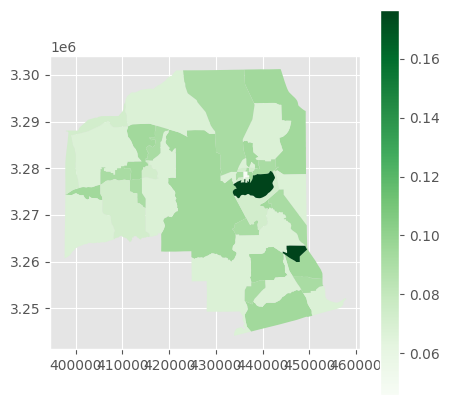

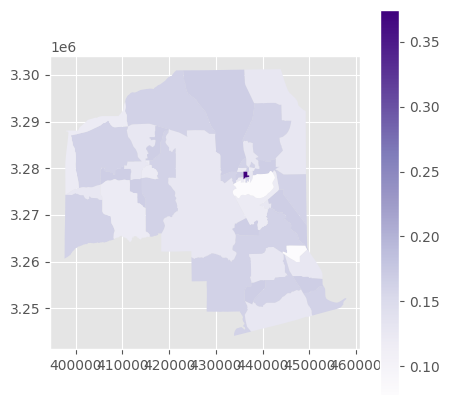

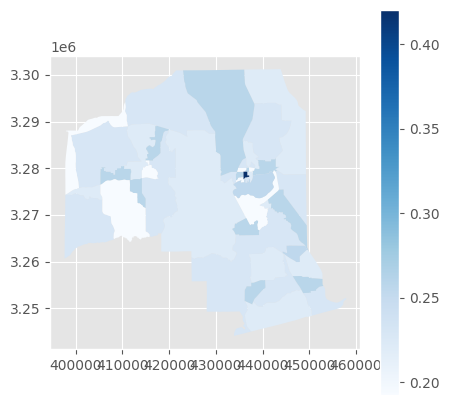

In [22]:
# Aggregate blocks to BLKGRP
blkgrp_aggregated = blocks.dissolve(by='BLKGRP', aggfunc='sum')
blkgrp_aggregated = blkgrp_aggregated.reset_index()

blkgrp_aggregated['vap_coalition_prop'] = blkgrp_aggregated['vap_coalition']/blkgrp_aggregated['P0040001']
blkgrp_aggregated['vap_black_prop'] = blkgrp_aggregated['abvap']/blkgrp_aggregated['P0040001']
blkgrp_aggregated['vap_hispanic_prop'] = blkgrp_aggregated['hvap']/blkgrp_aggregated['P0040001']

blkgrp_aggregated.plot(column='vap_hispanic_prop', cmap='Greens', legend=True, figsize=(5, 5))
blkgrp_aggregated.plot(column='vap_black_prop', cmap='Purples', legend=True, figsize=(5, 5))
blkgrp_aggregated.plot(column='vap_coalition_prop', cmap='Blues', legend=True, figsize=(5, 5))

In [128]:
updater = {
    "population": updaters.Tally(pop_col, alias="population"),
    "vap_pop": updaters.Tally("P0040001", alias="vap_pop"),
    "vap_black_pop": updaters.Tally("abvap", alias="vap_black_pop"),
    "vap_hispanic_pop": updaters.Tally("hvap", alias="vap_hispanic_pop"),
    "vap_coalition_pop": updaters.Tally("vap_coalition", alias="vap_coalition_pop"),
    "cvap": updaters.Tally("CVAP_TOT20", alias="cvap"),
    "cvap_black_pop": updaters.Tally("CVAP_BLK20", alias="cvap_black_pop"),
    "cvap_hispanic_pop": updaters.Tally("CVAP_HSP20", alias="cvap_hispanic_pop"),
    "cvap_coalition_pop": updaters.Tally("cvap_coalition", alias="cvap_coalition_pop"),
    "reock" : PartValue.calc_reock,
    "vtd_splits": LocalitySplits("vtd_splits", col_id='VTD', pop_col=pop_col),
    "place_splits": LocalitySplits("place_splits", col_id='PLACE', pop_col=pop_col)
}

initial_partition = Partition(
    graph,
    assignment="current_district",
    updaters=updater
)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col=pop_col,
    pop_target=ideal_population,
    epsilon=0.02, # Initial population deviation allowable by the validator as a percentage of the ideal population. Defaults to 0.05
    node_repeats=1 # A parameter for the algorithm: how many different choices of root to use before drawing a new spanning tree. Defaults to 1.
)

In [27]:
# population check
TOTPOP = sum(graph.nodes()[n][pop_col] for n in graph.nodes())
print(TOTPOP)
blocks.P0010001.sum()

73321


73321

<Axes: >

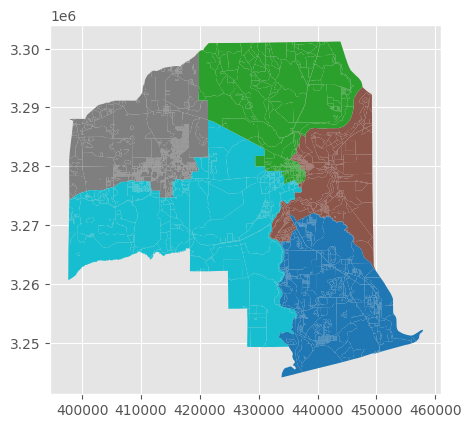

In [28]:
initial_partition.plot()

### Optimize for plans that allow for a Gingles I district

In [29]:
gingles_optimizer = Gingleator(
    proposal,
    constraints=[contiguous],
    initial_state=initial_partition,
    minority_pop_col="cvap_coalition_pop",
    total_pop_col="population",
    score_function=Gingleator.reward_partial_dist
)

In [30]:
init_vtd_split = list(initial_partition['vtd_splits'].values())[0]
init_place_split = list(initial_partition['place_splits'].values())[0]
init_reock = mean(initial_partition['reock'].values())
# init_polsby = mean(polsby_popper(initial_partition).values())

In [31]:
random.seed(99)

In [ ]:
tot_pop = []
pop_dev = []

vap_black = []
vap_hispanic = []
vap_coalition = []

cvap_black = []
cvap_hispanic = []
cvap_coalition = []

gingles_scores = []
black_props = []
hispanic_props = []
coalition_props = []

cvap_coalition_props = []
cvap_black_props = []
cvap_hispanic_props = []

reock_min = []
reock_avg = []
# polsby_popper_min = []
# polsby_popper_avg = []

vtd_splits = []
place_splits = []

t = 0
with open("./output-coalition_cvap/FL_output.jsonl", "w") as f:
    for i, part in enumerate(gingles_optimizer.short_bursts(5, 20000, with_progress_bar=True)):
        
        tot_pop.append(part["population"])
        vap_black.append(part["vap_black_pop"])
        vap_hispanic.append(part["vap_hispanic_pop"])
        vap_coalition.append(part["vap_coalition_pop"])
        
        cvap_black.append(part["cvap_black_pop"])
        cvap_hispanic.append(part["cvap_hispanic_pop"])
        cvap_coalition.append(part["cvap_coalition_pop"])
        
        dev = abs((min(part["population"].values()) / ideal_population) - (max(part["population"].values()) / ideal_population))
        pop_dev.append(dev)
        
        reock_min.append(min(part['reock'].values()))
        reock_score = mean(part['reock'].values())
        reock_avg.append(reock_score)
        
        # polsby_popper_min.append(min(polsby_popper(part).values()))
        # polsby_score = mean(polsby_popper(part).values())
        # polsby_popper_avg.append(polsby_score)
        
        vtd_split = int(list(part['vtd_splits'].values())[0])
        vtd_splits.append(vtd_split)
        
        place_split = int(list(part['place_splits'].values())[0])
        place_splits.append(place_split)
        
        vap_coalition_prop = demographic_shares({"vap_pop": ["vap_coalition_pop"]})[0].apply(part)
        coalition_props.append(vap_coalition_prop)
        
        vap_black_prop = demographic_shares({"vap_pop": ["vap_black_pop"]})[0].apply(part)
        black_props.append(vap_black_prop)
        
        vap_hispanic_prop = demographic_shares({"vap_pop": ["vap_hispanic_pop"]})[0].apply(part)
        hispanic_props.append(vap_hispanic_prop)
        
        cvap_coalition_prop = demographic_shares({"cvap": ["cvap_coalition_pop"]})[0].apply(part)
        cvap_coalition_props.append(cvap_coalition_prop)
        
        cvap_black_prop = demographic_shares({"cvap": ["cvap_black_pop"]})[0].apply(part)
        cvap_black_props.append(cvap_black_prop)
        
        cvap_hispanic_prop = demographic_shares({"cvap": ["cvap_hispanic_pop"]})[0].apply(part)
        cvap_hispanic_props.append(cvap_hispanic_prop)

        gd = gingles_districts({"cvap": ["cvap_coalition_pop"]}, threshold=0.5)[0].apply(part)
        gingles_scores.append(gd)

        if dev <= .04 and gd > 0:
            SavePart(num=t, dir='./output-coalition_cvap/').save_assignment(part)
            print(t, 'Gingles:', gd, 'Gingles prop:', round(max(cvap_coalition_prop.values()), 4), 'Pop dev: ', dev, 'VTD Splits: ', vtd_split, 'Reock: ', round(reock_score, 4))

        data = {
            "step": t,
            "populations": part["population"],
            "vtd_splits": vtd_split,
            "place_splits": place_split,
            "reock_score": reock_score,
            # "polsby_score": polsby_score,
            "vap_black_prop": vap_black_prop,
            "vap_hispanic_prop": vap_hispanic_prop,
            "vap_coalition_prop": vap_coalition_prop,
            "vap_black_pop": part["vap_black_pop"],
            "vap_hispanic_pop": part["vap_hispanic_pop"],
            "vap_coalition_pop": part["vap_coalition_pop"],
            "cvap_black_pop": part["cvap_black_pop"],
            "cvap_hispanic_pop": part["cvap_hispanic_pop"],
            "cvap_coalition_pop": part["cvap_coalition_pop"],
            "cvap_coalition_props": cvap_coalition_prop,
            "cvap_black_props": cvap_black_prop,
            "cvap_hispanic_props": cvap_hispanic_prop,
            "vap_tot": part["vap_pop"],
            "gingles_districts" : gd,
        }
            
        # Add newline character to separate entries in JSONL file
        f.write(json.dumps(data) + "\n")
        t +=1

In [34]:
gingles = [idx for idx, i in enumerate(gingles_scores) if i > 0]

(array([1.000e+00, 5.000e+00, 4.000e+00, 5.000e+00, 1.100e+01, 2.500e+01,
        5.500e+01, 1.450e+02, 3.220e+02, 6.360e+02, 9.930e+02, 1.491e+03,
        2.137e+03, 2.497e+03, 3.484e+03, 4.341e+03, 6.074e+03, 5.905e+03,
        6.434e+03, 5.930e+03]),
 array([0.01738929, 0.01851789, 0.01964649, 0.02077508, 0.02190368,
        0.02303228, 0.02416088, 0.02528948, 0.02641808, 0.02754668,
        0.02867528, 0.02980388, 0.03093248, 0.03206107, 0.03318967,
        0.03431827, 0.03544687, 0.03657547, 0.03770407, 0.03883267,
        0.03996127]),
 <BarContainer object of 20 artists>)

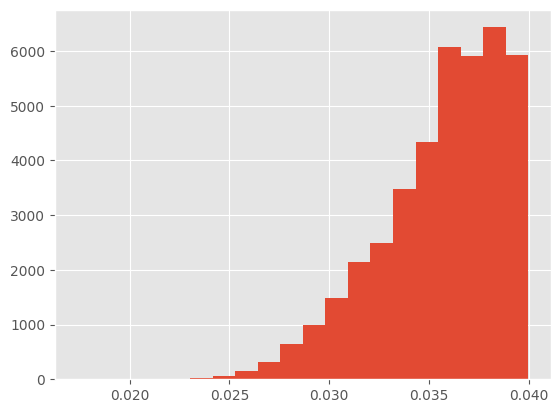

In [35]:
plt.hist([pop_dev[i] for i in gingles], bins=20)

In [85]:
ind_list = []
for ind in gingles:
  if pop_dev[ind] <= .03 and reock_avg[ind] >= init_reock and vtd_splits[ind] <= 55 and place_splits[ind] <= 14:
    ind_list.append(ind)
    print(ind, 'Gingles:', gingles_scores[ind], 'Gingles prop:', round(max(coalition_props[ind].values()), 4), 'Pop dev: ', pop_dev[ind], 'VTD Splits: ', vtd_splits[ind], 'Reock: ', round(reock_avg[ind], 4))

27531 Gingles: 1 Gingles prop: 0.5095 Pop dev:  0.026936348385864894 VTD Splits:  55 Reock:  0.4859
27551 Gingles: 1 Gingles prop: 0.5095 Pop dev:  0.02755008796934022 VTD Splits:  54 Reock:  0.4946
57902 Gingles: 1 Gingles prop: 0.5133 Pop dev:  0.02673176852470649 VTD Splits:  55 Reock:  0.4471


27531 0.5095 0.48594538844756874 55


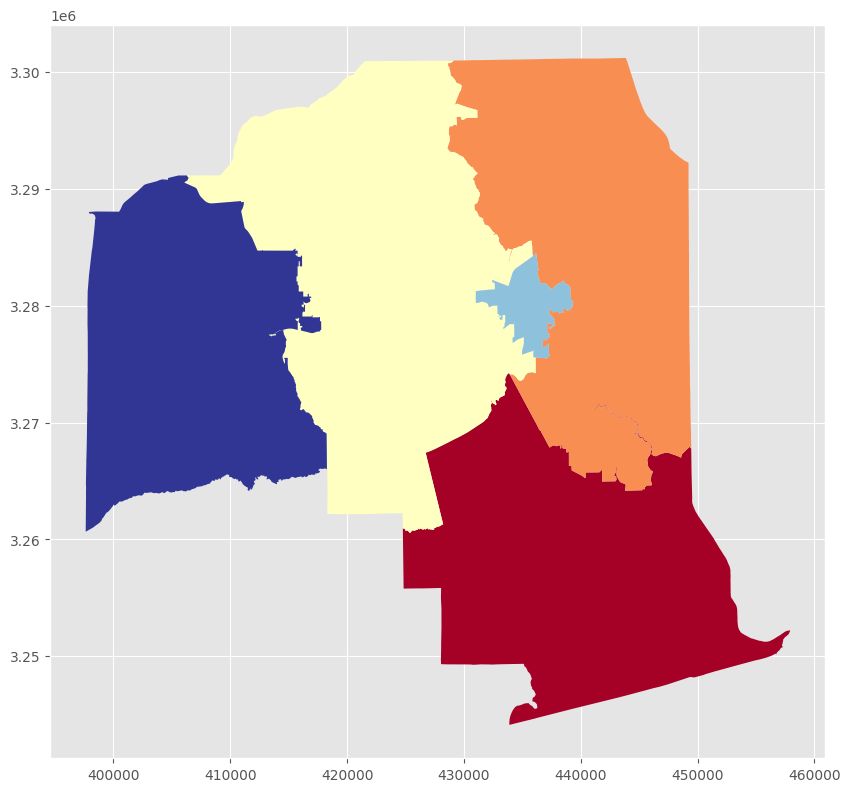

27551 0.5095 0.49460623851528607 54


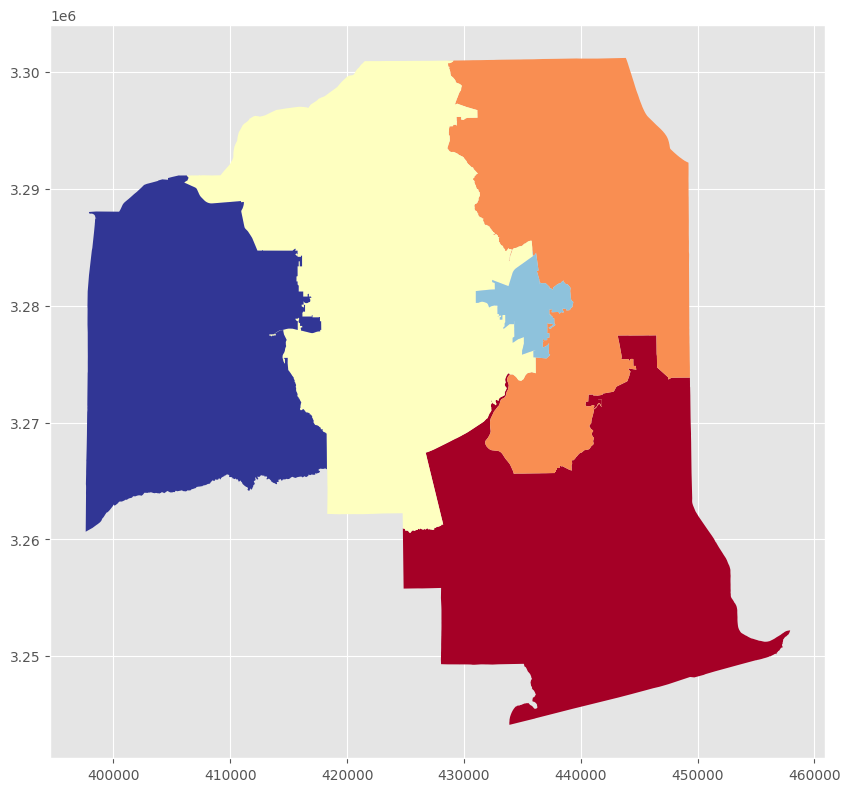

57902 0.5133 0.44706798579649903 55


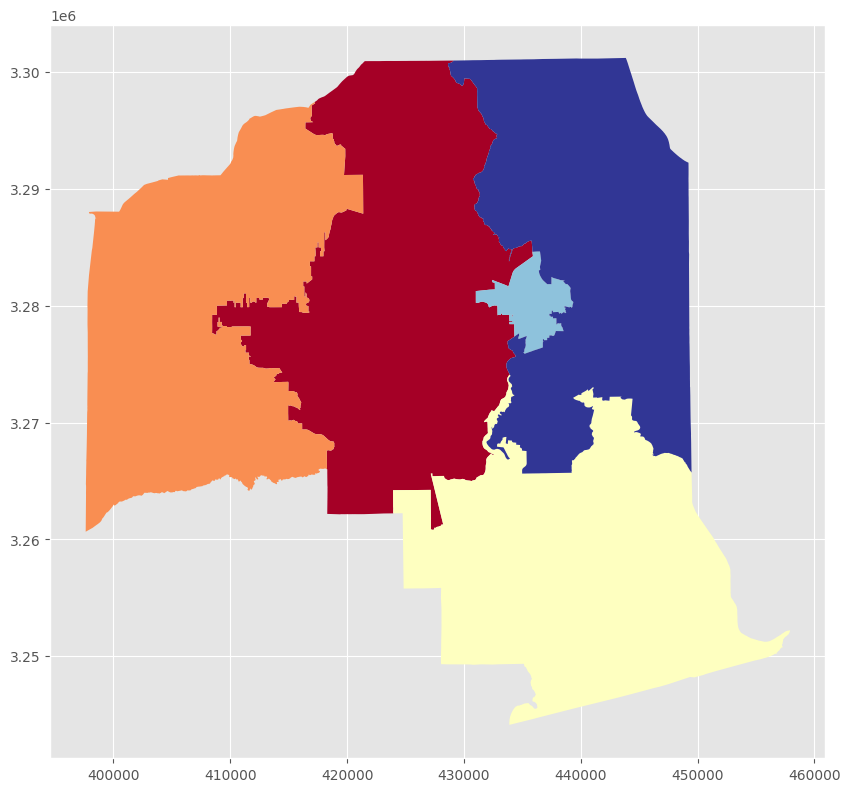

In [87]:
for num in ind_list:
  map = pd.read_csv(f'./output-coalition_cvap/FL_part_{num}.txt')
  map['GEOID'] = map['GEOID'].astype(str).str.zfill(15)
  print(num, round(max(coalition_props[num].values()), 4), reock_avg[num], vtd_splits[num])
  
  ### Map
  # Dissolve the blocks by 'DIST'
  dissolved_blocks = blocks.merge(map, on='GEOID', how='left').dissolve('DIST').reset_index()

  # Calculate centroids of the dissolved polygons
  dissolved_blocks['centroid'] = dissolved_blocks.geometry.centroid

  # Plot the dissolved polygons
  ax = dissolved_blocks.plot(column='DIST', cmap='RdYlBu', figsize=(10, 10), legend=False)

  plt.show()

In [71]:
init_place_split

14

In [88]:
ind_list = []
for ind in gingles:
  if pop_dev[ind] <= .04 and reock_min[ind] >= .43 and vtd_splits[ind] <= 55 and place_splits[ind] <= 15:
    ind_list.append(ind)
    print(ind, 'Gingles:', gingles_scores[ind], 'Gingles prop:', round(max(coalition_props[ind].values()), 4), 'Pop dev: ', pop_dev[ind], 'VTD Splits: ', vtd_splits[ind], 'Reock: ', round(reock_avg[ind], 4))
    # print('Black:', black_props[ind])
    # print('Hispanic:', hispanic_props[ind])
    # print('Coalition:', coalition_props[ind])
    # print('CVAP Coalition:', cvap_coalition_props[ind])
    # print('CVAP Black:', cvap_black_props[ind])
    # print('CVAP Hispanic:', cvap_hispanic_props[ind])

70150 Gingles: 1 Gingles prop: 0.5139 Pop dev:  0.030482399312611652 VTD Splits:  53 Reock:  0.5033


70150 0.5139 0.5032646122154714 53


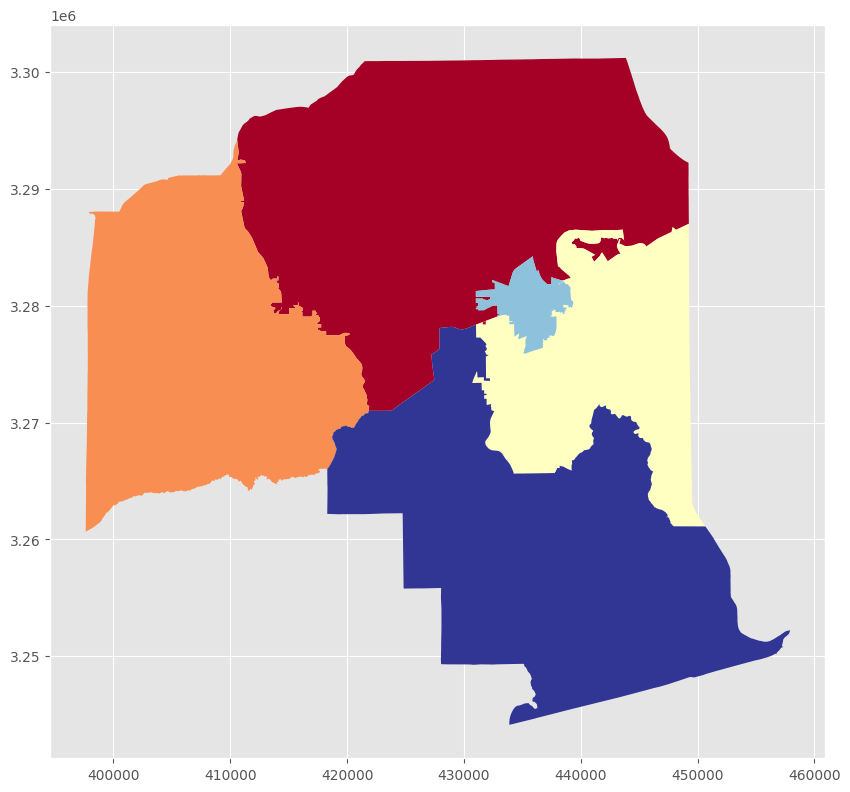

In [106]:
for num in ind_list:
  map = pd.read_csv(f'./output-coalition_cvap/FL_part_{num}.txt')
  map['GEOID'] = map['GEOID'].astype(str).str.zfill(15)
  print(num, round(max(coalition_props[num].values()), 4), reock_avg[num], vtd_splits[num])
  
  ### Map
  # Dissolve the blocks by 'DIST'
  dissolved_blocks = blocks.merge(map, on='GEOID', how='left').dissolve('DIST').reset_index()

  # Calculate centroids of the dissolved polygons
  dissolved_blocks['centroid'] = dissolved_blocks.geometry.centroid

  # Plot the dissolved polygons
  ax = dissolved_blocks.plot(column='DIST', cmap='RdYlBu', figsize=(10, 10), legend=False)
  
  plt.show()